## Eyes Classification

**Implementing Neural Network Classifier to determine Gender by Eyes Images**

### Importing all the necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from os.path import split
import glob
import os
import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
from tensorflow.keras import optimizers
from keras.layers import BatchNormalization

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report,confusion_matrix,precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow_addons as tfa 

import warnings
warnings.filterwarnings("ignore")

## Getting the data (images) and labels 

In [2]:

male_img_path = list(glob.glob('image/males/*.jpg'))


female_img_path = list(glob.glob('image/females/*.jpg'))

male_categ = []
male_label = []

for i in range(len(male_img_path)):
    male_categ.append('Male')
    male_label.append(0)
    
female_categ = []
female_label = []
    
for i in range(len(female_img_path)):
    female_categ.append('Female')
    female_label.append(1)

combined_image = male_img_path + female_img_path
combined_categ = male_categ + female_categ
combined_label = male_label + female_label


image = pd.Series(combined_image, name='Image').astype(str)
category = pd.Series(combined_categ, name='Category').astype(str)
labels = pd.Series(combined_label, name='Labels').astype(int)

df = pd.concat([image, category, labels],axis=1).sample(frac=1,random_state= 111)
df.reset_index(inplace=True, drop= True)
df.head()

,Image,Category,Labels
0,image/males\4811.jpg,Male,0
1,image/males\4173.jpg,Male,0
2,image/females\3442.jpg,Female,1
3,image/males\5881.jpg,Male,0
4,image/females\518.jpg,Female,1


### EDA and Image Visualization

In [3]:
df.shape

(11525, 3)

In [4]:
df.isna().sum()

Image       0
Category    0
Labels      0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11525 entries, 0 to 11524
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     11525 non-null  object
 1   Category  11525 non-null  object
 2   Labels    11525 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 225.2+ KB


In [7]:
df.Labels.value_counts()

0    6323
1    5202
Name: Labels, dtype: int64

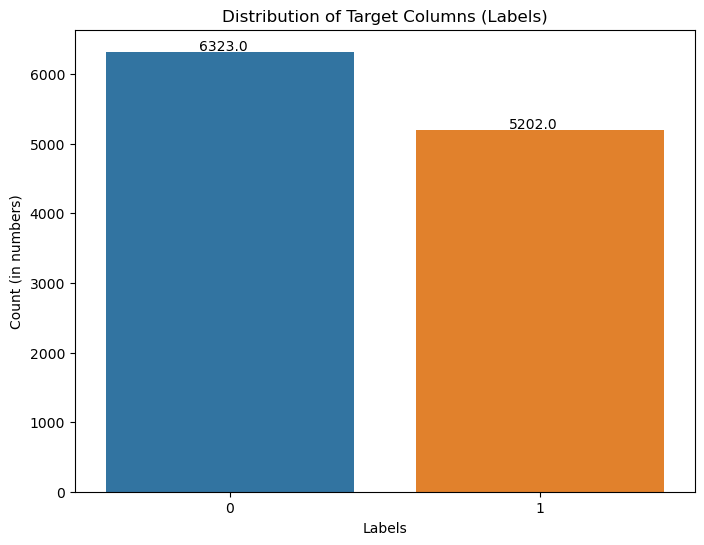

In [8]:
plt.figure(figsize=(8,6))

ax = sns.countplot(x='Labels', data=df)
plt.title('Distribution of Target Columns (Labels)')
plt.xlabel('Labels')
plt.ylabel('Count (in numbers)')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.3, p.get_height()+20))

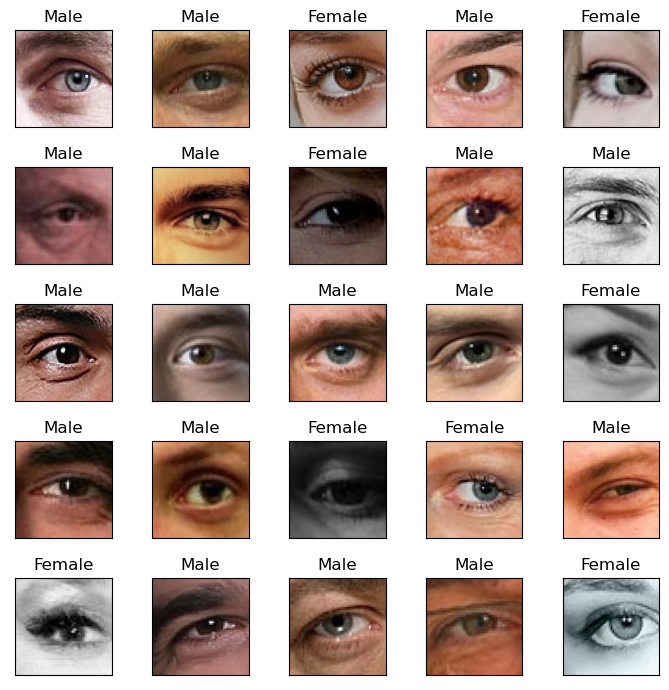

In [9]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["Image"][i]))
    ax.set_title(df["Category"][i])
plt.tight_layout()
plt.show()

We have created a dataframe with all the images of male and female eyes. We have 11525 rows and 3 columns. The 3 columns have the image path, image category and image label. The path and category are of object type and label is of integer type. 



In [10]:
df1 = df.copy()

In [11]:
for i in range(len(df1)):
    image = cv2.imread(df1['Image'][i])
    image=cv2.resize(image,(100,100))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    df1['Image'][i] = image.flatten()

In [12]:
df1 = df1.drop("Category",axis=1)
df1.head()

,Image,Labels
0,"[205, 171, 172, 199, 166, 167, 193, 159, 160, ...",0
1,"[217, 174, 132, 217, 175, 133, 218, 176, 134, ...",0
2,"[141, 95, 71, 131, 85, 61, 115, 70, 46, 128, 8...",1
3,"[241, 192, 177, 239, 190, 175, 236, 187, 172, ...",0
4,"[99, 85, 76, 100, 86, 77, 103, 89, 78, 106, 91...",1


Resizing the images to 100 pixel, to make all the images uniform. We have also changes the shape of the images from 3d to 1d array using flatten numpy function so as to pass it to knn model. We have dropped the category column as the knn model only takes the integer values.


### Model 1 - KNN Classifier

We will be using KNN Classifier from Sklearn. This model will be a benchmark model and we will be trying to bet it with other models.

In [13]:
def cleaned(X):
    for i in range(len(X)):
        X[i] = np.vstack(X[i].reset_index(drop=True))
    return X

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df1['Image'], df1['Labels'], test_size=0.2, random_state=111)
X_train, X_test, y_train, y_test = cleaned([X_train, X_test, y_train, y_test])

In [15]:
for dataset in [y_train, y_test]:
    print(round(len(dataset) / len( df1['Labels']), 2))

0.8
0.2


In [16]:
print("X Train", X_train.shape)
print("y Train", y_train.shape)
print("X Test", X_test.shape)
print("y Test", y_test.shape)

X Train (9220, 30000)
y Train (9220, 1)
X Test (2305, 30000)
y Test (2305, 1)


> Dividing the dataset into train and test.

In [17]:
knn = KNeighborsClassifier(n_neighbors=15,n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=15)

In [18]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 4)
    precision = round(precision_score(labels, pred,average='weighted'), 4)
    recall = round(recall_score(labels, pred, average='weighted'), 4)
    confusion_m = confusion_matrix(labels, pred)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))
    print('\n')
    print(confusion_m)
    print('\n')
    print(classification_report(labels,pred, target_names=['Male','Female']))

In [19]:
evaluate_model('KNN', knn, X_test, y_test)

KNN -- Accuracy: 0.8338 / Precision: 0.8422 / Recall: 0.8338 / Latency: 13373.7ms


[[1172   89]
 [ 294  750]]


              precision    recall  f1-score   support

        Male       0.80      0.93      0.86      1261
      Female       0.89      0.72      0.80      1044

    accuracy                           0.83      2305
   macro avg       0.85      0.82      0.83      2305
weighted avg       0.84      0.83      0.83      2305



The knn model worked really nice than expected. It gave us an overall accuracy and recall of 0.8338 and precision of 0.8422. 

The model seems to not accurately predict the male eye images. As shown in the confusion matrix, the model predicted 294 images as female eyes but it were actually male. This might be the reason for the low accuracy which we got. The problem might get fixed by using more data or by doing more hyper-parameter tuning. 

The KNN model also took a lot of time to predict the results which can not be feasible in the real-world sceniero.

## Model 2: Multi-Layer Perceptron



Again dividing the dataset into train, test and validation. We need the validation dataset, for the loss and accuracy curve.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(df1['Image'], df1['Labels'], test_size=0.2, random_state=111)
X_val, X_test,y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 111)

X_train, X_val, X_test, y_train, y_val, y_test = cleaned([X_train, X_val, X_test, y_train, y_val, y_test])

In [21]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len( df1['Labels']), 2))

0.8
0.1
0.1


In [22]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [23]:
X_train

array([[-3.92142217e-01, -6.54928801e-01, -5.32254939e-01, ...,
        -1.19765217e-01, -8.81380330e-01, -8.05627178e-01],
       [-3.36348489e+00, -2.77924508e+00, -2.32158853e+00, ...,
         8.20578139e-01,  1.73164489e+00,  1.95495290e+00],
       [ 1.11142877e+00,  8.91722522e-01,  9.17105274e-01, ...,
         9.93799283e-01,  6.86434799e-01,  6.46233454e-01],
       ...,
       [-7.85934619e-01, -9.58982027e-02,  2.55051844e-01, ...,
         1.27693560e-01,  1.09543005e+00,  1.38238814e+00],
       [-4.10041872e-01, -1.32576552e+00, -1.46270841e+00, ...,
        -5.15699262e-01, -9.94990122e-01, -1.03056333e+00],
       [-8.78480881e-02, -2.72643629e-03,  1.65585164e-01, ...,
        -2.18748729e-01, -2.22443537e-01, -2.85750090e-02]])

Scaling the values for better performance and to remove any ambigious results.

In [24]:
print("X_Train: ", X_train.shape) 
print("X_Val: ", X_val.shape) 
print("X_Test: ", X_test.shape) 
print("y_Train: ", y_train.shape) 
print("y_Val: ", y_val.shape) 
print("y_test: ", y_test.shape) 

X_Train:  (9220, 30000)
X_Val:  (1152, 30000)
X_Test:  (1153, 30000)
y_Train:  (9220, 1)
y_Val:  (1152, 1)
y_test:  (1153, 1)


In [25]:
mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1:])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(126, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])

### Architecture of the neural network


We have a simple, 3 layer multi-layer perceptron model. 

The first hidden layer has 512 nodes with relu activation layer. We have added dropout for preventing the model from overfitting. 

The second layer has 126 nodes again with relu activation layer followed by a dropout layer and finally we have a output layer with 1 node since, its a binary classification and sigmoid function is used to get the binary results.

In [26]:
BATCH_SIZE = 50

n_epochs = 30

optimizer = optimizers.Adam(learning_rate=0.001)

mlp.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy",'Precision','Recall'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model_1.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')


# Actual fitting of the model
history = mlp.fit(x=X_train, y=y_train,
                    epochs=n_epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, checkpointer],
                    verbose=1,
                 batch_size = BATCH_SIZE)

Epoch 1/30
185/185 [==============================] - ETA: 0s - loss: 2.6175 - accuracy: 0.7206 - precision: 0.6985 - recall: 0.6693
Epoch 1: val_loss improved from inf to 0.53755, saving model to img_model_1.weights.best.hdf5
185/185 [==============================] - 11s 46ms/step - loss: 2.6175 - accuracy: 0.7206 - precision: 0.6985 - recall: 0.6693 - val_loss: 0.5376 - val_accuracy: 0.8030 - val_precision: 0.7796 - val_recall: 0.8015
Epoch 2/30
184/185 [============================>.] - ETA: 0s - loss: 0.4767 - accuracy: 0.7930 - precision: 0.7882 - recall: 0.7395
Epoch 2: val_loss improved from 0.53755 to 0.39984, saving model to img_model_1.weights.best.hdf5
185/185 [==============================] - 8s 45ms/step - loss: 0.4764 - accuracy: 0.7932 - precision: 0.7884 - recall: 0.7400 - val_loss: 0.3998 - val_accuracy: 0.8411 - val_precision: 0.8774 - val_recall: 0.7640
Epoch 3/30
184/185 [============================>.] - ETA: 0s - loss: 0.3767 - accuracy: 0.8403 - precision: 0.83

Here, we have used Adam as our optimizer with 0.001 learning rate. Since it is a binary classification, we are using binary_crossentropy for loss calculation. 

After every epoch, if we have any improvement in the model, we save the model and can use it for prediction purpose later on. Also, we have used another layer of preventing overfitting, the EarlyStopping function which monitors val_loss for 20 iteration and if it is same then it stops the training process and gives us an nicely fitted model. However, the model didn't stop and gave us continuous imporvement over the previous model. 

We got a training accuracy of 0.93, precision of 0.94 and recall of 0.90 which is very high compared to the baseline model.

In [27]:
score = mlp.evaluate(X_test,y_test)
print('\n')
print(f' Accuracy: {score[1]} \n Precision: {score[2]} \n Recall:{score[3]}')

37/37 [==============================] - 0s 8ms/step - loss: 0.2584 - accuracy: 0.9063 - precision: 0.9069 - recall: 0.8784


 Accuracy: 0.9063313007354736 
 Precision: 0.9068825840950012 
 Recall:0.8784313797950745


The score for test data was also high compared to the baseline model obtained form KNN. We got an accuracy and precision of 0.90 and recall of 0.87 which is quite high. Also, the mlp model trained faster than the KNN model.

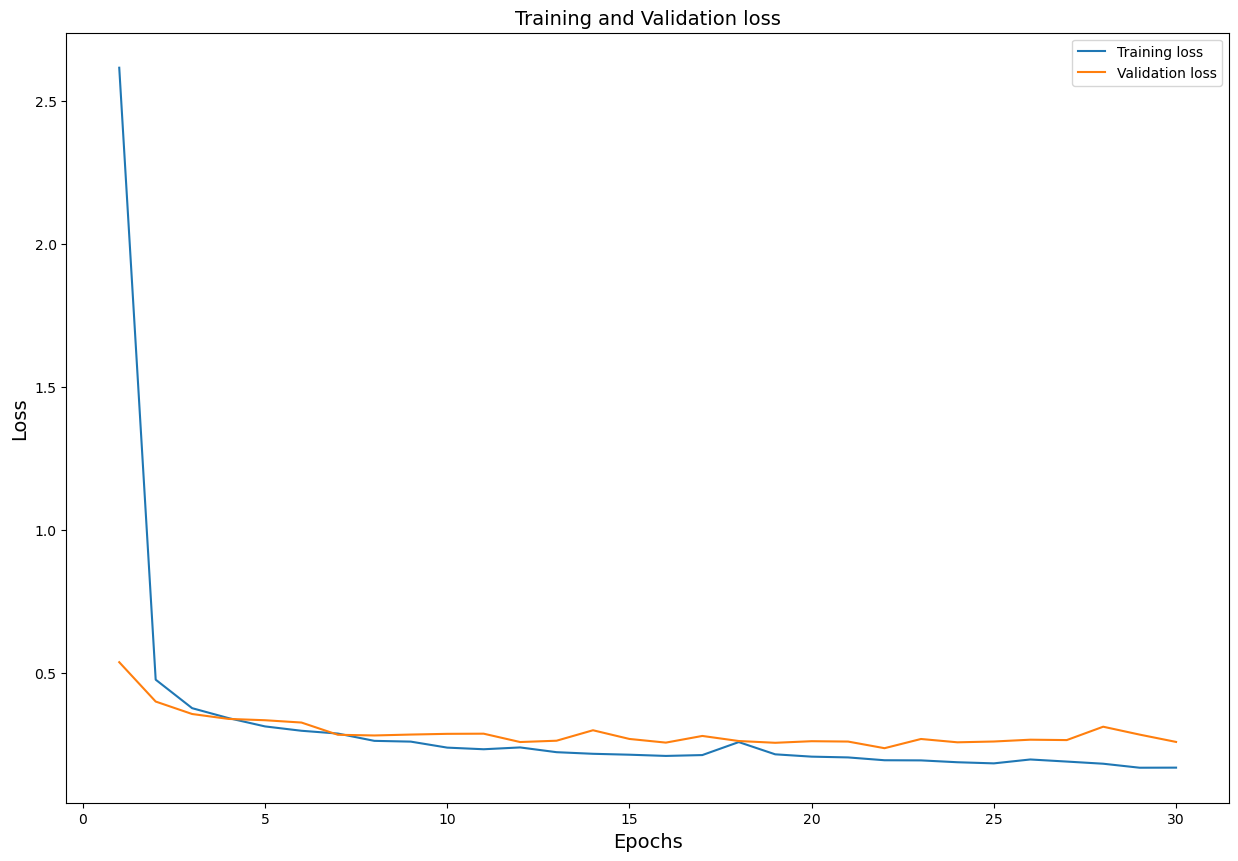

In [28]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.figure(figsize = (15, 10))

plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and Validation loss',size=14)
plt.xlabel('Epochs',size=14)
plt.ylabel('Loss',size=14)
plt.legend()

plt.show()

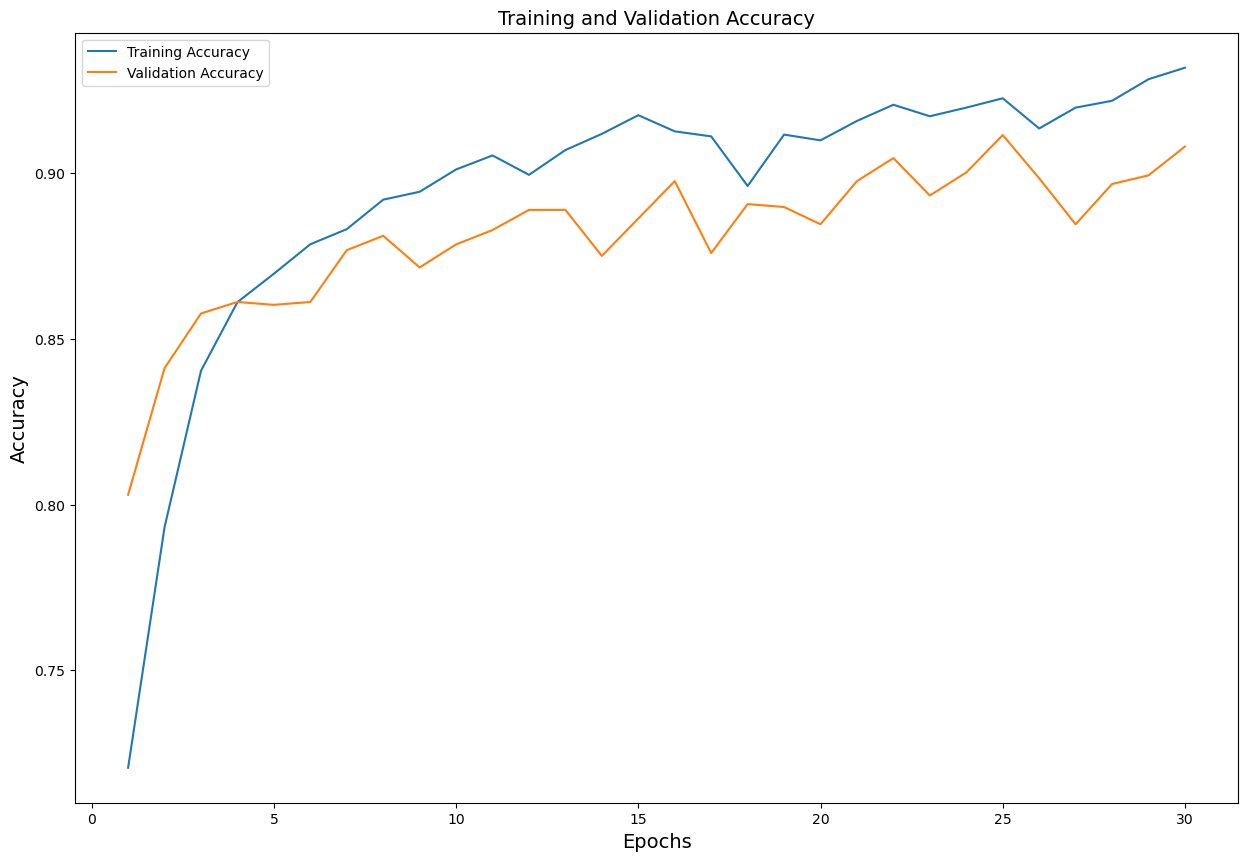

In [29]:
history_dict = history.history

loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize = (15, 10))

plt.plot(epochs, loss_values, label='Training Accuracy')
plt.plot(epochs, val_loss_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy',size=14)
plt.xlabel('Epochs',size=14)
plt.ylabel('Accuracy',size=14)
plt.legend()

plt.show()

Looking at the loss and accuracy curve, we can say that, the dropout and earlystopping method were able to stop overfitting problem and the model looks good. The difference between two curves are not that significant which indicates the model is not overfitting or underfitting.

## Model 3: Convolution Neural Network

In [30]:
train_generator = ImageDataGenerator(
    rescale=1/255.,              
    brightness_range=[0.1, 0.7], 
    width_shift_range=0.5,       
    rotation_range=90,           
    horizontal_flip=True,        
    vertical_flip=True,          
    validation_split=0.15        
)

The ImageDataGenerator class helps to generate batches of tensor image data with **real time data augmentation.** The class will rescale our images between 0 and 1 value, increase and decrease the brightness of the image with the range of 0.1 to 0.7, shift the width of image by 50%, rotate the image, flip the image in horizontal and vertical angles.

In [31]:
BATCH_SIZE = 32


traingen = train_generator.flow_from_directory('cnn/train',
                                               target_size=(100, 100),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory('cnn/test',
                                               target_size=(100, 100),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 8097 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [32]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('cnn/test',
                                             target_size=(100, 100),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=42)

Found 2000 images belonging to 2 classes.


For the training of our model, we have 8097 images while 300 images are used for validation of our model during training stage. The images are divided into 2 classes.

The ImageDataGenerator is also being used in test data but here we are only rescaling our test images i.e, normalizing our data. We don't perform any data augmentation. For test our model, we have 2000 images of 2 classes

In [33]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu',kernel_initializer='glorot_uniform' ,input_shape=(100, 100, 3)))

model.add(Conv2D(32, (3,3), activation='relu',kernel_initializer='glorot_uniform')) 
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))  
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu',kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(1024, activation='relu',kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu',kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 64)       

### Architecture of the neural network

Here, we have build a CNN model for classifying the male and female eyes. 

We have used 4 layers of CNN in our model with batchnormalization, MaxPooling and dropout layer. We have used relu activation function with kernel size of 3 by 3. The padding is kept same in all the layers and the kernel intializer is taken as glorot uniform. The filter size is kept on increasing form 32, 64, 128 while keeping the kernal size same as the inital value which is 3 by 3. For MaxPooling, 2 by 2 kernal size is being used. 

After the convolution layers, we use the flatten method to make a array and used dense layer of 1024 neuron with dropout value of 0.2. Finally, the last hidden layer is a dense layer with 512 neuron which gives it output to output layer. For the output layer, we used softmax activation function.

We have a total of 19,504,610 parameter and amoung them, 19,504,162 are trainable parameter and 448 are non-trainable parameter.

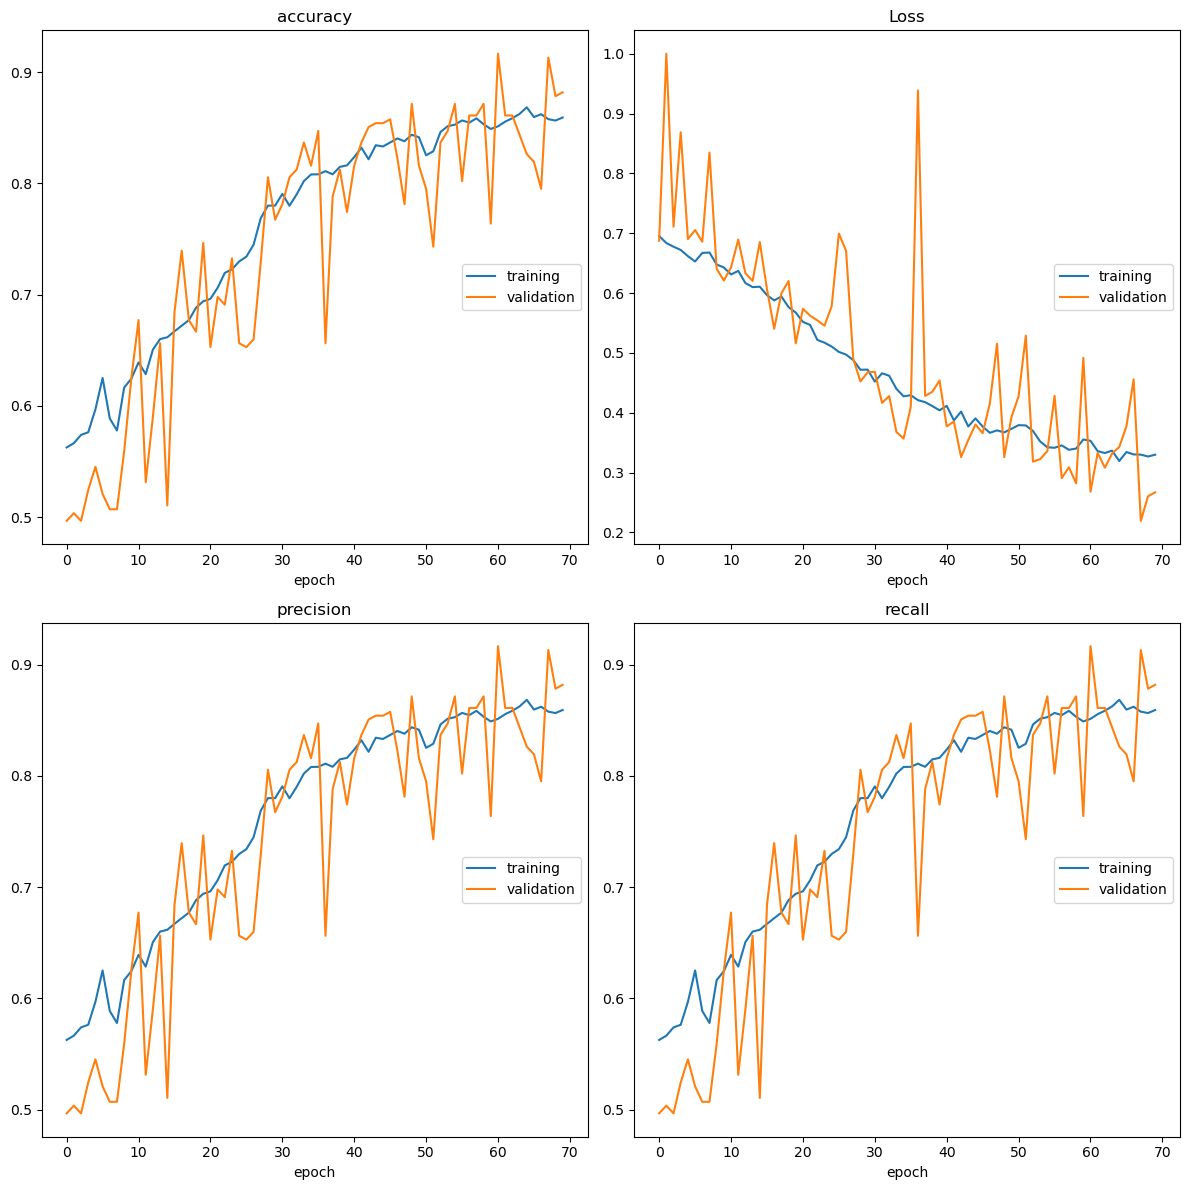

accuracy
	training         	 (min:    0.563, max:    0.868, cur:    0.859)
	validation       	 (min:    0.497, max:    0.917, cur:    0.882)
Loss
	training         	 (min:    0.319, max:    0.695, cur:    0.330)
	validation       	 (min:    0.219, max:    1.000, cur:    0.267)
precision
	training         	 (min:    0.563, max:    0.868, cur:    0.859)
	validation       	 (min:    0.497, max:    0.917, cur:    0.882)
recall
	training         	 (min:    0.563, max:    0.868, cur:    0.859)
	validation       	 (min:    0.497, max:    0.917, cur:    0.882)

253/253 [==============================] - 68s 270ms/step - loss: 0.3299 - accuracy: 0.8593 - precision: 0.8593 - recall: 0.8593 - val_loss: 0.2671 - val_accuracy: 0.8819 - val_precision: 0.8819 - val_recall: 0.8819


In [35]:
steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 70

optimizer = optimizers.Adam(learning_rate = 0.001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy",'Precision','Recall'])

checkpointer = ModelCheckpoint(filepath='img_model_cnn.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=1)

From the graphs, we can clearly see that, our model is not overfitting or underfitting. The difference between val_loss and loss is quite low. The batchnormalization and Dropout layer did their job as intended.

We ran the algorithm for 70 epoch with early stopping. The early stopping didn't came to play as the model was improving in every epoch. We have saved the best model which can be used for prediction purpose of testing data. 

We have a training loss of 0.3299 and accuracy of 0.85 which is lower than MLP model. The simpler model was able to bet the CNN model which has different technique for increasing the accuracy. However, the dataset is of only 2 classification problem. When we have higher number of classes like 9, 10. The CNN model can be highly effective. 

Also, we only ran the model for 70 epoch, if we had ran the model for another 30 epoch, it might be able to bit the MLP model but to do computational power and time-complexicity and the problem of overfitting, we have ran the model to 70 epoch.

In [36]:
model.load_weights('img_model_cnn.weights.best.hdf5')

predicted_classes = np.argmax(model.predict(testgen), axis=-1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

2000/2000 [==============================] - 19s 9ms/step


In [37]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

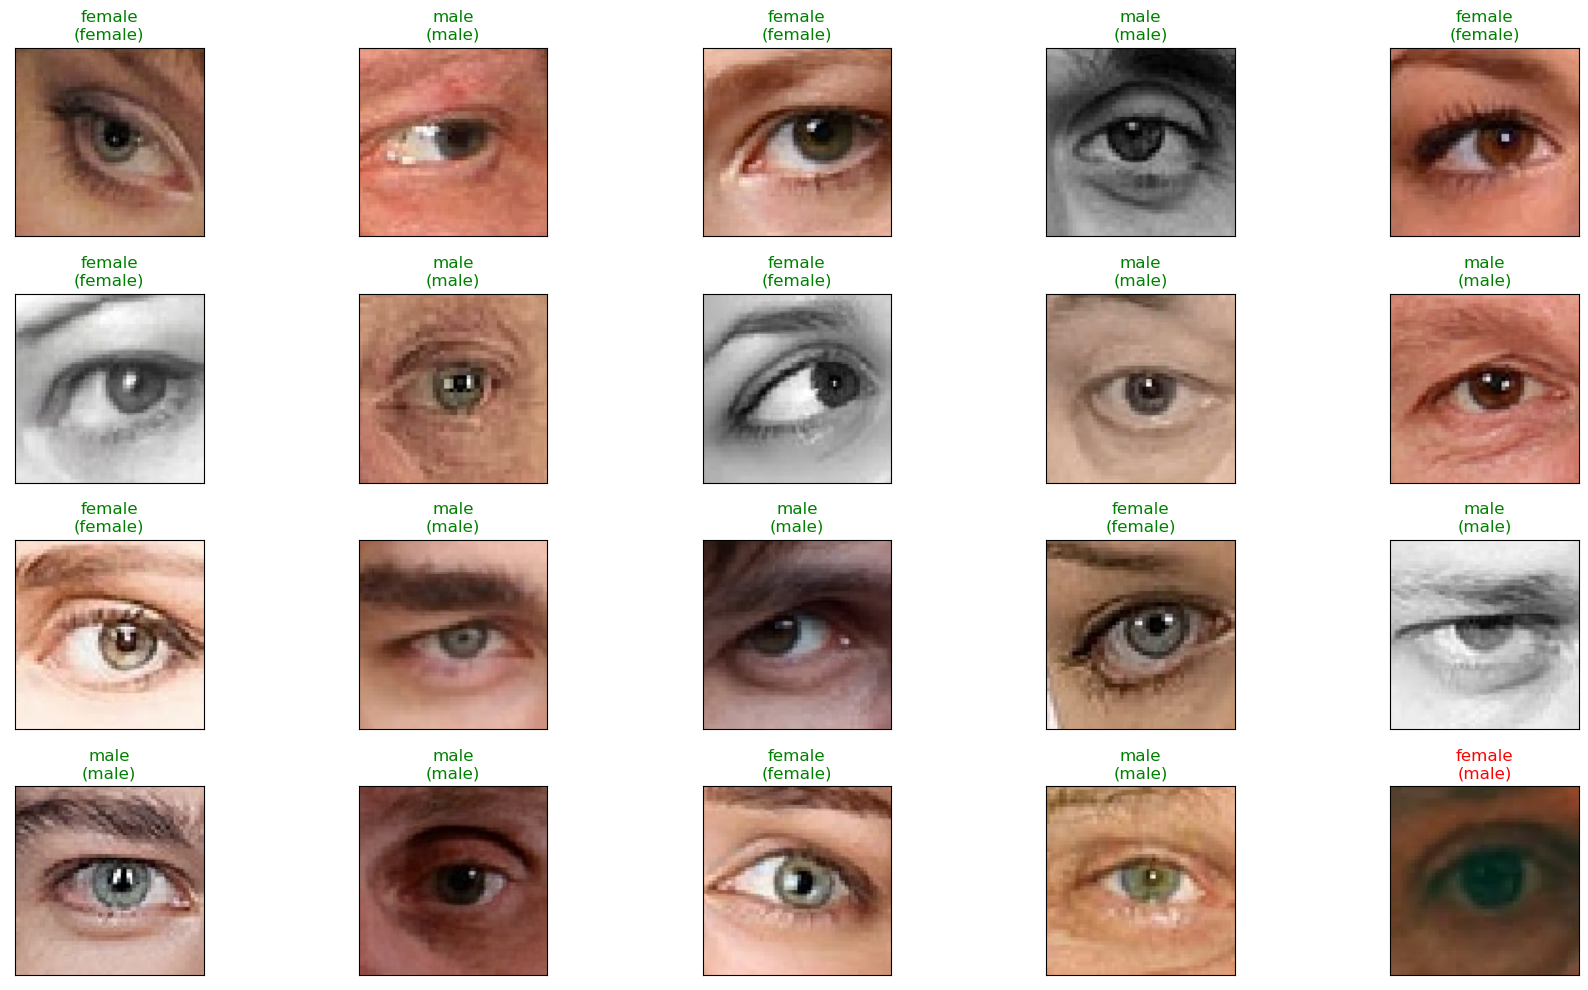

In [38]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [39]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 88.20%


,Precision,Recall,F-Score,Support
male,0.875984,0.890,0.882937,1000.0
female,0.888211,0.874,0.881048,1000.0


We have a high overall accuracy of the model 88.20% which is quite close to the MLP model accuracy of 0.90. We could have increase the model accuracy if we had ran the model for more epoch with high number of data.

## Conclusion:

1. Both the MLP model and CNN model are able to bit the baseline KNN model.
2. Simple three layer MLP model is performing better than the complex 4 layer CNN model. This might be because of the low number of classes and dataset.
3. Both the MLP and CNN model, according to the loss and accuracy graph seems to not be overfitting or underfitting.
4. All the 3 models were able to get an accuary of more than 80%.